# Multiple Seasonalities

> In this example we show how to forecast a time series dataset with multiple seasonalities

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/MultipleSeasonalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing StatsForecast Library

In [ ]:
%%capture
!pip install statsforecast datasetsforecast

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL

#### Useful functions

The `plot_grid` function defined below will be useful to plot different time series, and different models' forecasts.

In [ ]:
def plot_grid(df_train, df_test=None, plot_random=True, level=None, anomalies=False):
    fig, axes = plt.subplots(3, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 6, "Must provide at least 6 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=6)
    else:
        unique_uids = unique_ids[:6]

    for uid, (idx, idy) in zip(unique_ids, product(range(3), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if level is not None and anomalies: 
            axes[idx, idy].fill_between(
                train_uid['ds'], 
                train_uid[f'MSTL-lo-{level}'], 
                train_uid[f'MSTL-hi-{level}'],
                alpha=0.9,
                color='orange',
                label=f'MSTL_level_{level}',
            )
            filt = (train_uid['y'] > train_uid[f'MSTL-hi-{level}']) | (train_uid[f'MSTL-lo-{level}'] > train_uid['y'])
            anomalies_df = train_uid[filt][['ds', 'y']]
            axes[idx, idy].scatter(
                anomalies_df['ds'],
                anomalies_df['y'],
                color='red',
                label='Anomalies'
            )
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            models = df_test.drop(['unique_id', 'ds'], axis=1).columns
            for model in models:
                if all(np.isnan(test_uid[model])):
                    continue
                if 'lo' in model or 'hi' in model:
                    continue
                axes[idx, idy].plot(test_uid['ds'], 
                                    test_uid[model], 
                                    label=model, 
                                    linewidth=3.5)
            if level is not None:
                for l in level:
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'MSTL-lo-{l}'], 
                        test_uid[f'MSTL-hi-{l}'],
                        alpha=1 - l // 100,
                        color='orange',
                        label=f'MSTL_level_{l}',
                    )
        axes[idx, idy].set_title(f'ETTm1: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(10))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## Download data

In this example, we will use the electriciy [ETT](https://github.com/zhouhaoyi/ETDataset) (15 minutes frequency).

In [ ]:
train, *_ = LongHorizon.load('./data', 'ETTm1')
train = train.groupby('unique_id').tail(30_000) # we consider only the last 30k obs
train['ds'] = pd.to_datetime(train['ds'])

In [ ]:
train.tail()

,unique_id,ds,y
403195,OT,2018-02-20 22:45:00,-1.644488
403196,OT,2018-02-20 23:00:00,-1.613855
403197,OT,2018-02-20 23:15:00,-1.590853
403198,OT,2018-02-20 23:30:00,-1.567742
403199,OT,2018-02-20 23:45:00,-1.575482


In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [ ]:
n_series = 6
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')

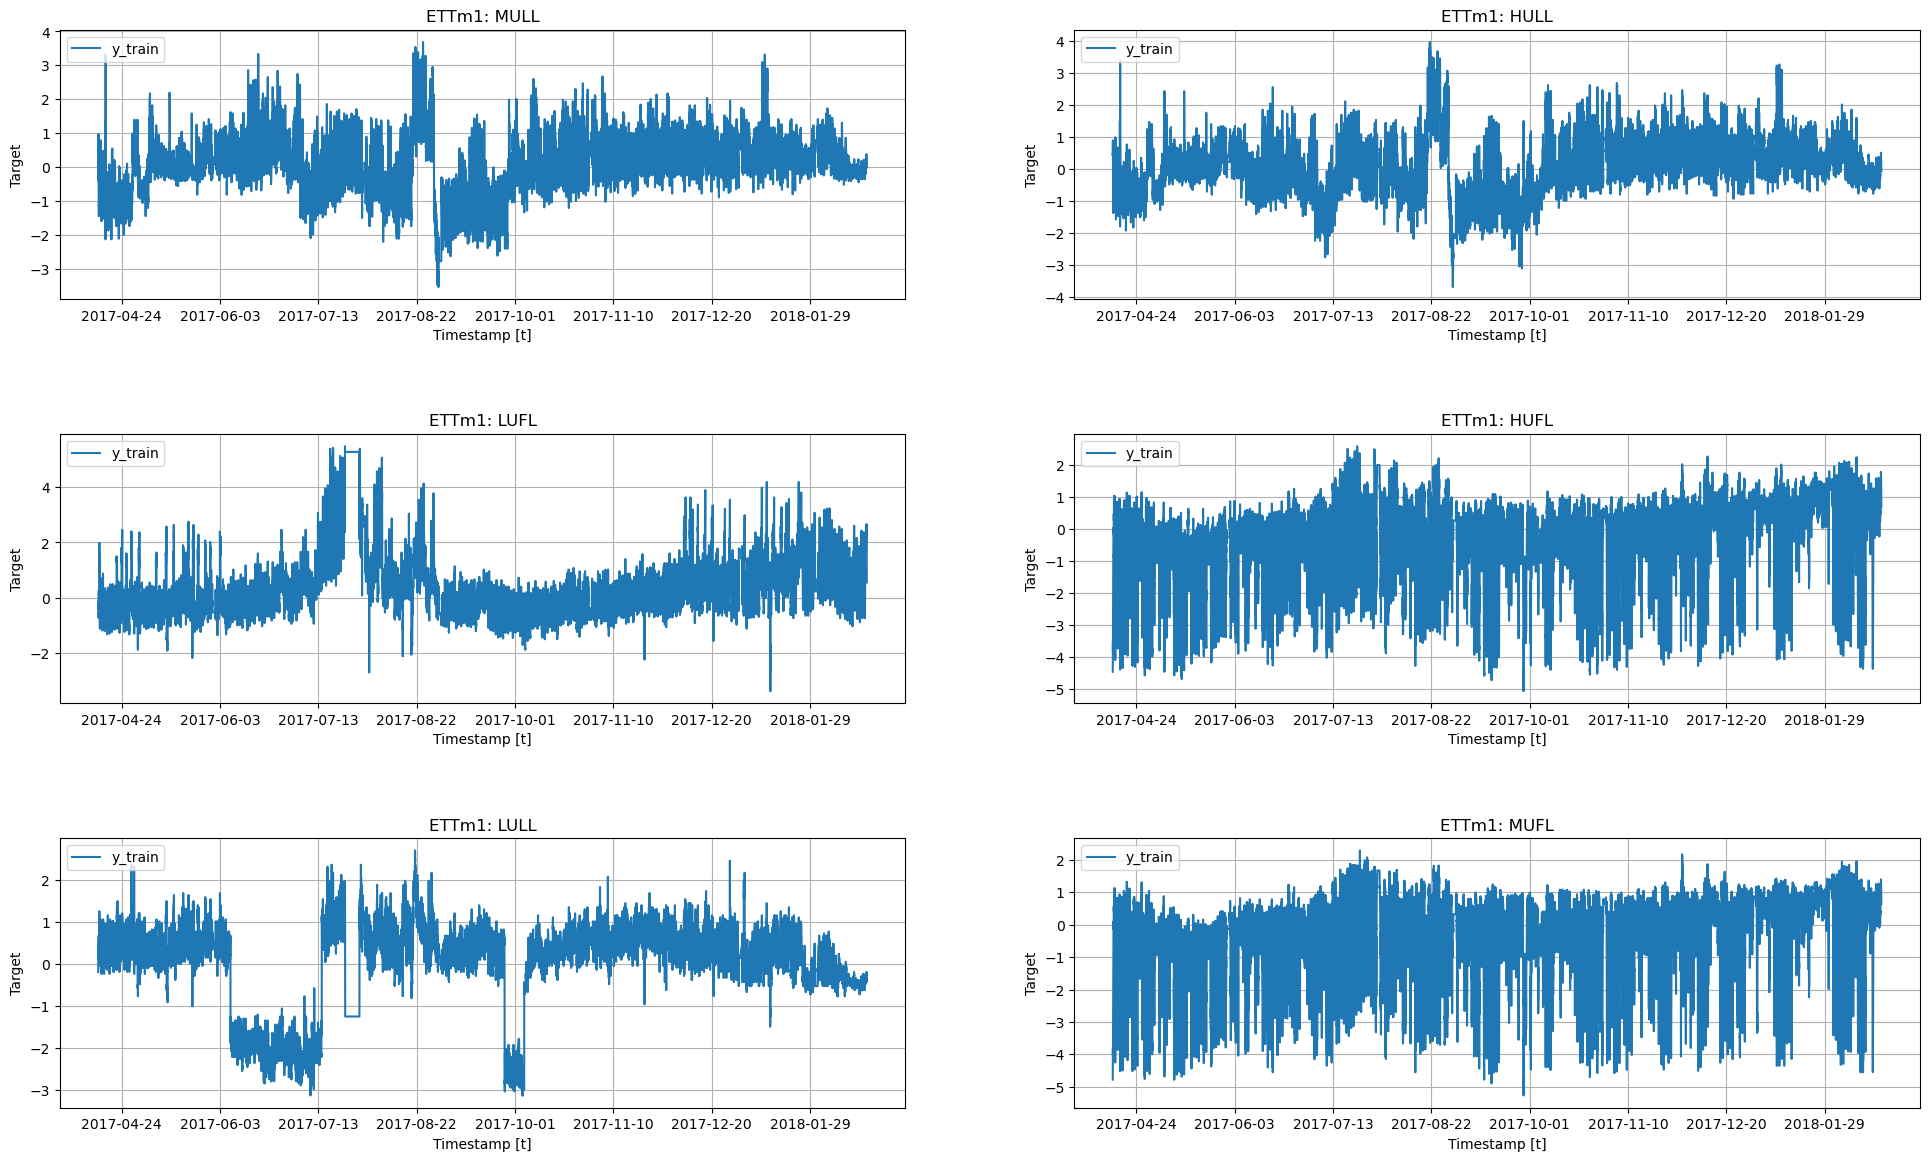

In [ ]:
plot_grid(train)

## Efficient forecast and anomaly detection

`StatsForecast` receives a list of models to fit each time series. Since we are dealing with 15 minutes data, we can pass Hourly seasonality (4), Daily seasonality (4 * 24) and Weekly seasonality (4 * 24 * 7) to the `MSTL` model. We will use the `AutoARIMA` model to forecast the trend component of `MSTL`. 

In this section we will use the `forecast` method of `StatsForecast`. The method is computationally efficient.

In [ ]:
models = [
    MSTL(season_length=[4, 4 * 24, 4 * 24 * 7], trend_forecaster=AutoARIMA()),
    # if you want, you can add other models here, example:
    # Naive()
]

In [ ]:
fcst = StatsForecast(df=train, 
                     models=models, 
                     freq='15T', 
                     n_jobs=-1)

We can define the level of the forecast intervals we want to produce. StatsForecast will produce these levels for both forecasts and intra-sample forecasts.

In [ ]:
levels = [80, 90, 95, 99]

Observe that we need to pass `fitted=True` to the `forecast` method to recover the insample forecasts.

In [ ]:
%%time
forecasts = fcst.forecast(h=6 * 24, fitted=True, level=levels)

CPU times: user 51.5 ms, sys: 69.1 ms, total: 121 ms
Wall time: 43.3 s


In [ ]:
forecasts = forecasts.reset_index()

In [ ]:
forecasts.head()

,unique_id,ds,MSTL,MSTL-lo-99,MSTL-lo-95,MSTL-lo-90,MSTL-lo-80,MSTL-hi-80,MSTL-hi-90,MSTL-hi-95,MSTL-hi-99
0,HUFL,2018-02-21 00:00:00,0.807572,0.280089,0.406207,0.470736,0.545134,1.070011,1.144409,1.208938,1.335056
1,HUFL,2018-02-21 00:15:00,0.773038,0.128908,0.282915,0.361714,0.452564,1.093512,1.184362,1.263161,1.417169
2,HUFL,2018-02-21 00:30:00,0.700928,-0.041750,0.135820,0.226674,0.331424,1.070432,1.175181,1.266035,1.443605
3,HUFL,2018-02-21 00:45:00,0.630362,-0.199238,-0.000885,0.100602,0.217611,1.043112,1.160121,1.261609,1.459961
4,HUFL,2018-02-21 01:00:00,0.574014,-0.334226,-0.117072,-0.005963,0.122137,1.025891,1.153991,1.265100,1.482254


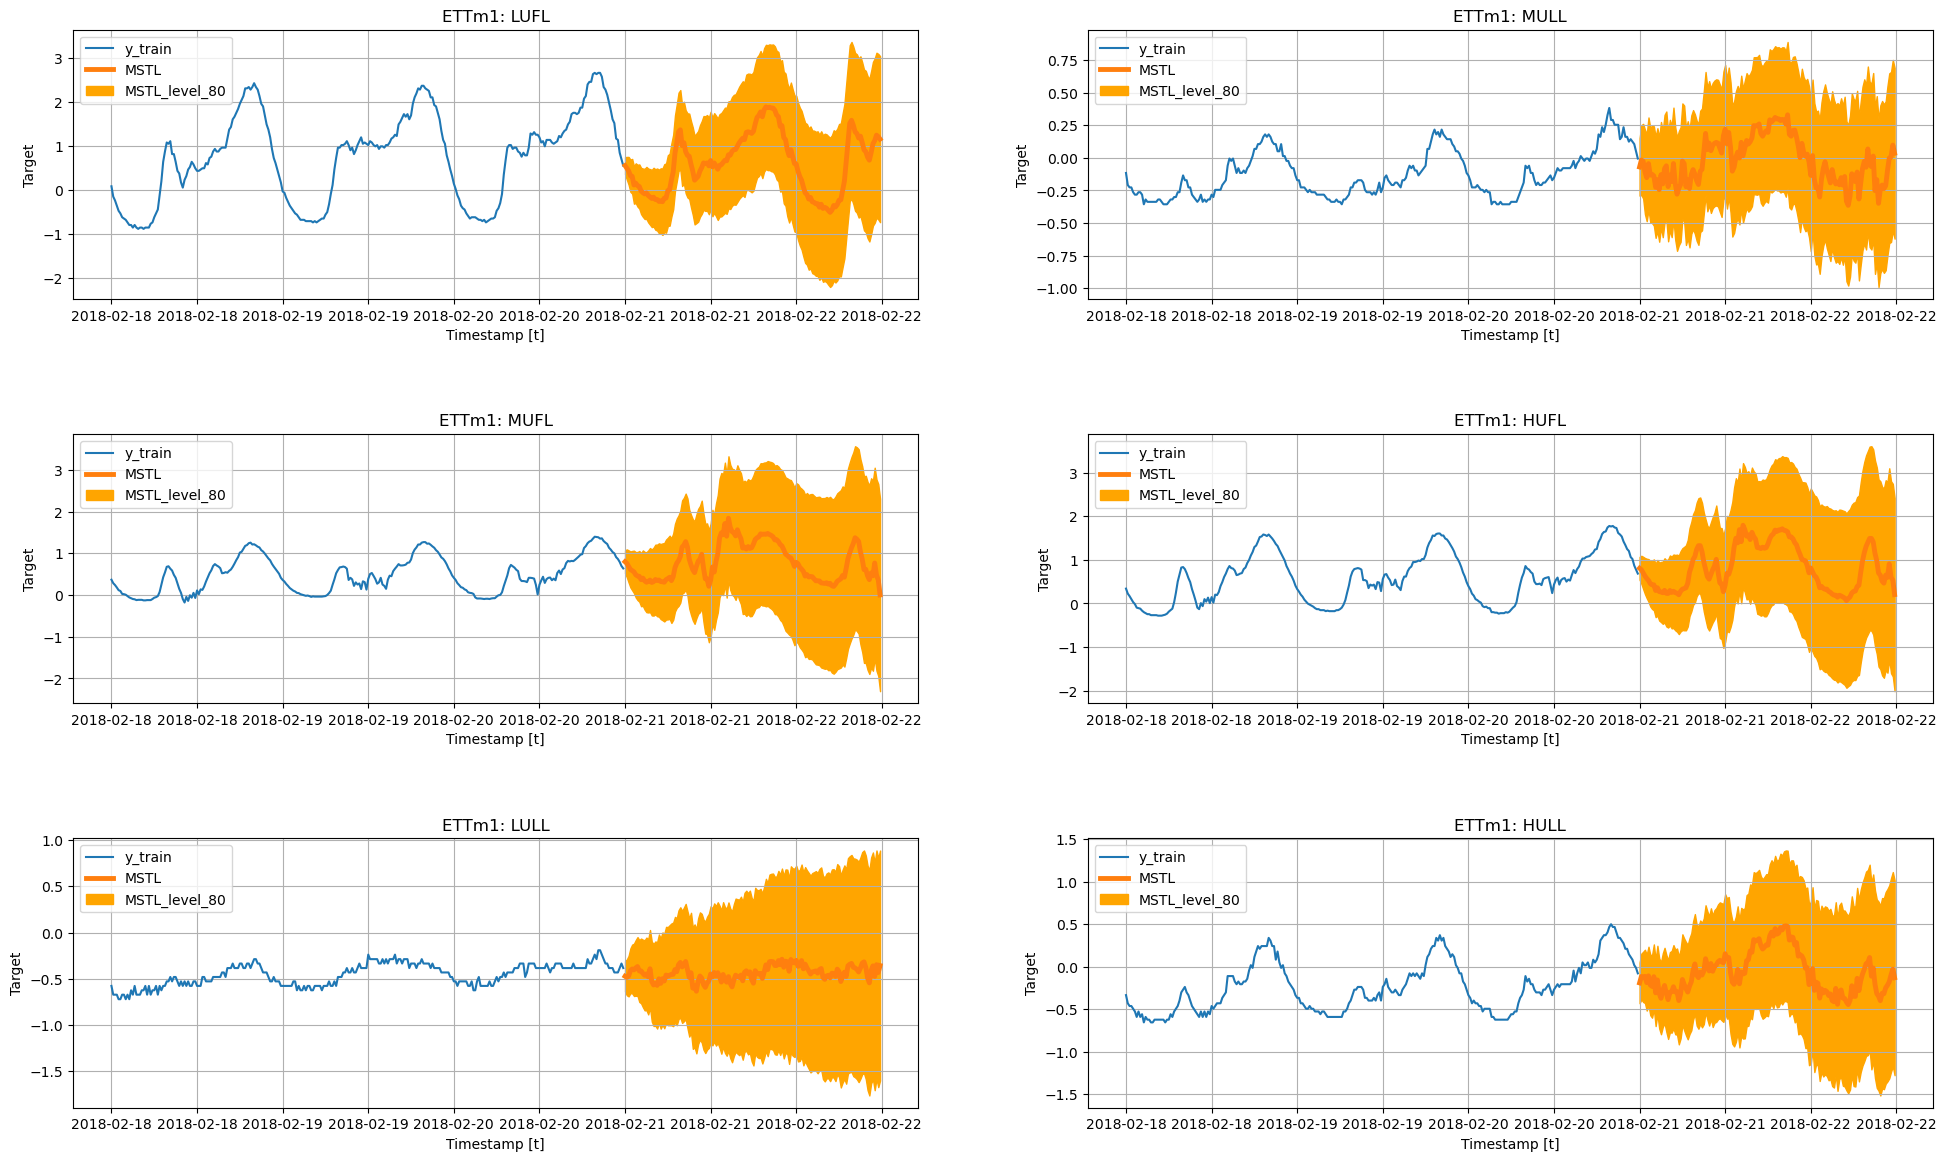

In [ ]:
plot_grid(train.groupby('unique_id').tail(6 * 24 * 2), forecasts, level=[80])

### Recover insample forecasts

Once the model is fitted, we can recover the insample forecasts and their prediction intervals using `forecast_fitted_values`.

In [ ]:
insample_forecasts = fcst.forecast_fitted_values().reset_index()

In [ ]:
insample_forecasts.head()

,unique_id,ds,y,MSTL,MSTL-lo-99,MSTL-lo-95,MSTL-lo-90,MSTL-lo-80,MSTL-hi-80,MSTL-hi-90,MSTL-hi-95,MSTL-hi-99
0,HUFL,2017-04-14 12:00:00,-4.458701,-4.458244,-4.985727,-4.859609,-4.795080,-4.720683,-4.195806,-4.121408,-4.056879,-3.930761
1,HUFL,2017-04-14 12:15:00,-4.125601,-3.975490,-4.502974,-4.376855,-4.312326,-4.237929,-3.713052,-3.638654,-3.574125,-3.448007
2,HUFL,2017-04-14 12:30:00,-4.206005,-4.254372,-4.781855,-4.655737,-4.591208,-4.516810,-3.991933,-3.917535,-3.853006,-3.726888
3,HUFL,2017-04-14 12:45:00,-4.010739,-4.050205,-4.577689,-4.451571,-4.387042,-4.312644,-3.787767,-3.713369,-3.648840,-3.522722
4,HUFL,2017-04-14 13:00:00,-3.999253,-3.845741,-4.373224,-4.247106,-4.182578,-4.108180,-3.583302,-3.508905,-3.444376,-3.318258


### Plot anomalies

In this example, we consider as an anomaly an observation that is above the upper prediction interval or below the lower prediction interval of a certain probability level.

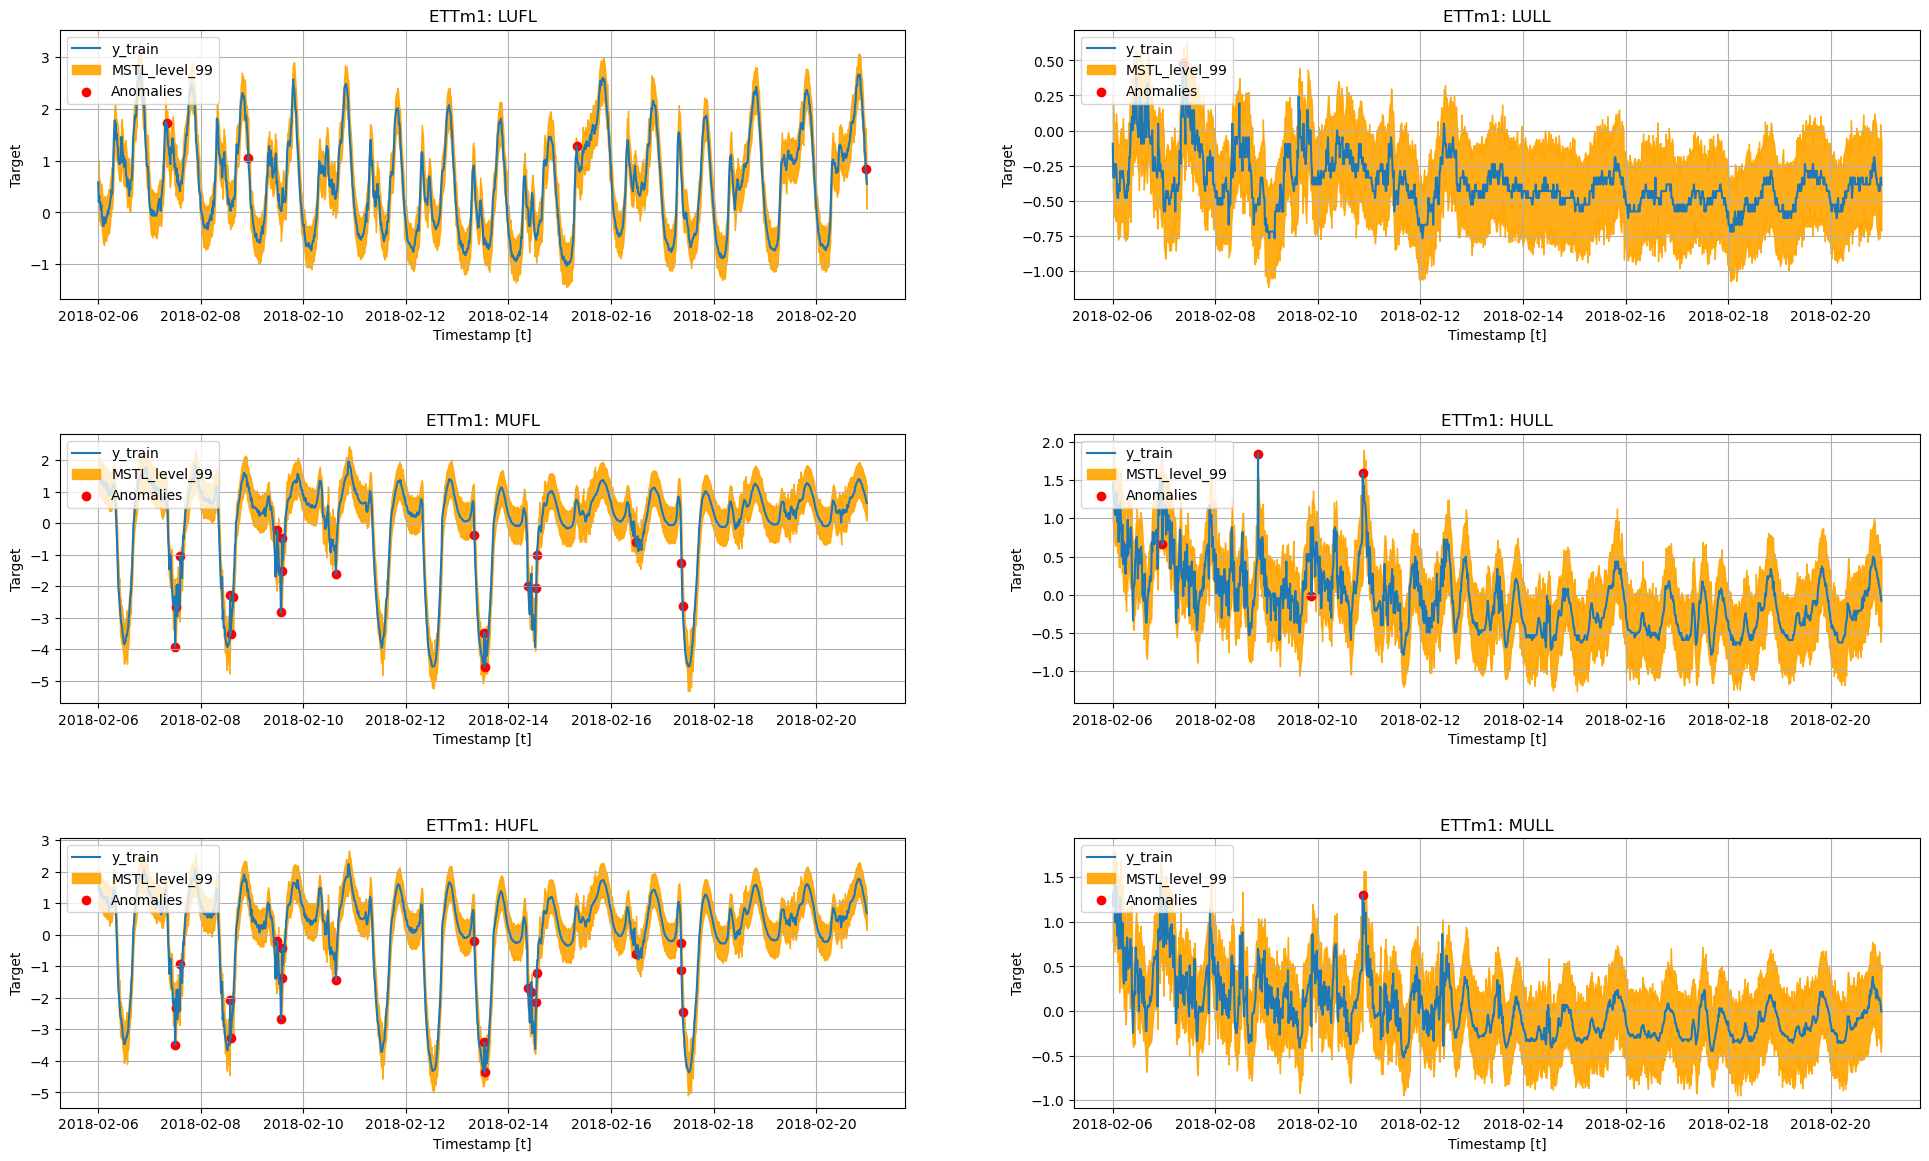

In [ ]:
plot_grid(insample_forecasts.groupby('unique_id').tail(6 * 24 * 10),
          level=99, anomalies=True)

## Visualize components

To visualize the components of the `MSTL` model we can use the `fit` method of `StatsForecast`. The method stores the relevant information of the models although it is not as computationally efficient as forecast.

In [ ]:
fcst = fcst.fit()

<AxesSubplot: >

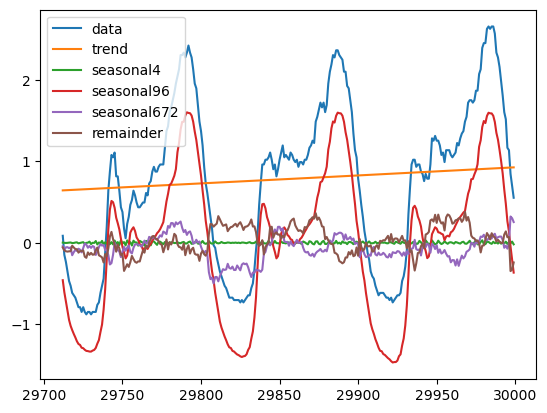

In [ ]:
fcst.fitted_[2,0].model_.tail(6 * 24 * 2).plot()

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/MultipleSeasonalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>